In [5]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
import zipfile

# Step 1: Mount your Google Drive
drive.mount('/content/drive')

# Step 2: Unzip the dataset folder
# Assuming the zip file is in the path '/content/drive/MyDrive/HV-AI-2024/dataset.zip'
zip_file_path = '/content/drive/MyDrive/birds_dataset/dataset.zip'
unzip_dir = '/content/dataset/HV-AI-2024'  # Destination directory

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Step 3: Define paths after unzipping
train_images_path = os.path.join(unzip_dir, 'images/train')
test_images_path = os.path.join(unzip_dir, 'images/test')

# Load CSV files
train_csv_path = os.path.join(unzip_dir, 'train.csv')
test_csv_path = os.path.join(unzip_dir, 'test.csv')

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Convert 'class' column to string type for categorical classification
train_df['class'] = train_df['class'].astype(str)

# Ensure paths are updated correctly after unzipping
train_df['path'] = train_df['path'].apply(lambda x: os.path.join(train_images_path, os.path.basename(x)))
test_df['path'] = test_df['path'].apply(lambda x: os.path.join(test_images_path, os.path.basename(x)))

# Preprocessing and augmentation settings
image_size = (224, 224)
batch_size = 32

# Split train data into train and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)

# ImageDataGenerator for train and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_data, x_col='path', y_col='class',
    target_size=image_size, batch_size=batch_size, class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    val_data, x_col='path', y_col='class',
    target_size=image_size, batch_size=batch_size, class_mode='categorical')

# Test generator (no labels)
test_generator = val_datagen.flow_from_dataframe(
    test_df, x_col='path', y_col=None,
    target_size=image_size, batch_size=batch_size, class_mode=None, shuffle=False)

# Build the model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Number of classes
num_classes = len(train_generator.class_indices)

# Custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['class']), y=train_df['class'])
class_weights_dict = dict(enumerate(class_weights))

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/HV-AI-2024/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4795 validated image filenames belonging to 200 classes.
Found 1199 validated image filenames belonging to 200 classes.
Found 5794 validated image filenames.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.0119 - loss: 6.5324
Epoch 1: val_loss improved from inf to 5.77236, saving model to /content/drive/MyDrive/HV-AI-2024/best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 183s 826ms/step - accuracy: 0.0120 - loss: 6.5311 - val_accuracy: 0.0609 - val_loss: 5.7724 - learning_rate: 1.0000e-04
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.1085 - loss: 5.4931
Epoch 2: val_loss improved from 5.77236 to 4.45595, saving model to /content/drive/MyDrive/HV-AI-2024/best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 556ms/step - accuracy: 0.1087 - loss: 5.4912 - val_accuracy: 0.2093 - val_loss: 4.4559 - learning_rate: 1.0000e-04
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.2506 - loss: 4.2602
Epoch 3: val_loss improved from 4.45595 to 3.83108, saving model to /content/drive/MyDrive/HV-AI-2024/best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 138s 530ms/step - accuracy: 0.2508 - loss: 4.2593 - val_accuracy: 0.

In [6]:
# Make predictions on the test set
predictions = model.predict(test_generator)

# Find the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Map predicted class indices to actual labels
class_indices = {v: k for k, v in train_generator.class_indices.items()}
predicted_labels = [class_indices[p] for p in predicted_classes]

# Save predictions to a CSV file
results_df = pd.DataFrame({
    'image_path': test_df['path'],
    'predicted_class': predicted_labels
})
results_df.to_csv('/content/drive/MyDrive/HV-AI-2024/predictions.csv', index=False)
print("Predictions saved to predictions.csv")

182/182 ━━━━━━━━━━━━━━━━━━━━ 33s 159ms/step
Predictions saved to predictions.csv


In [7]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)

# Get the predicted class for each image by taking the argmax of the predicted probabilities
predicted_classes = np.argmax(predictions, axis=1)

# Map the predicted classes to their corresponding class labels
class_indices = {v: k for k, v in train_generator.class_indices.items()}
predicted_labels = [class_indices[p] for p in predicted_classes]

# Display the first few predictions
print("Predicted labels for test set images:")
print(predicted_labels[:10])

182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step
Predicted labels for test set images:
['129', '20', '70', '63', '84', '139', '193', '46', '51', '96']


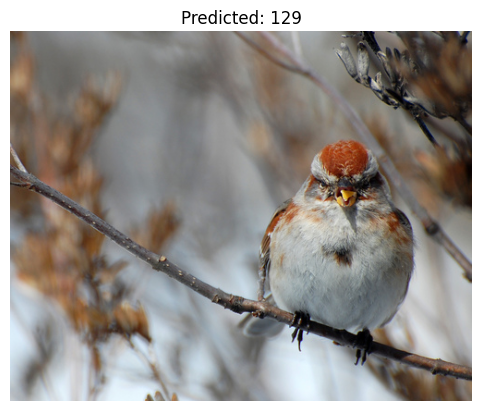

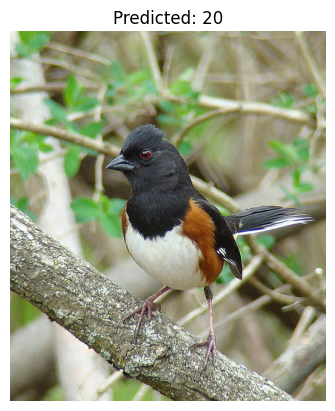

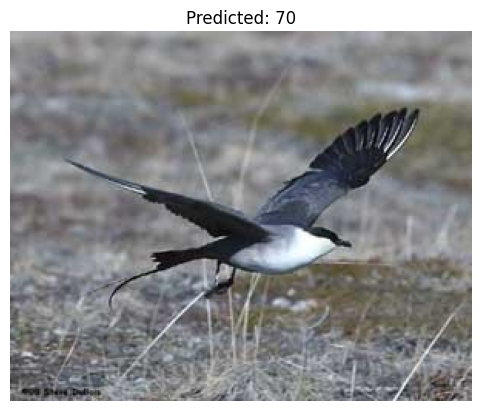

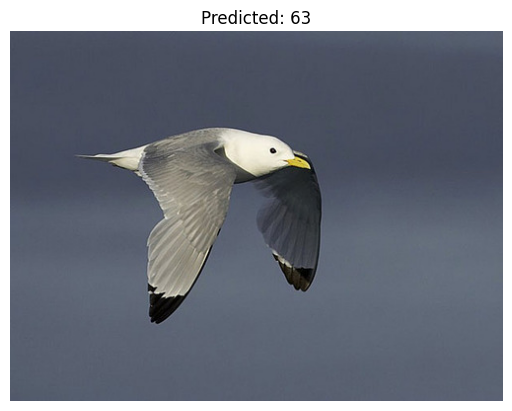

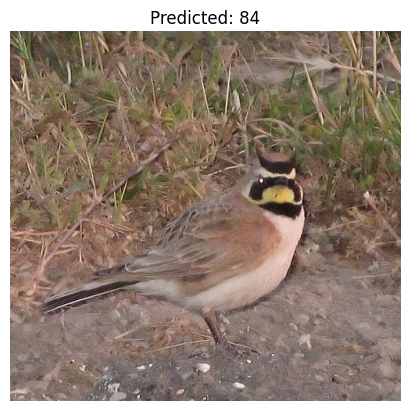

In [8]:
import matplotlib.pyplot as plt

# Get the file paths of the test images
test_image_paths = test_df['path'].tolist()

# Visualize the first 5 test images along with their predicted labels
for i in range(5):
    img_path = os.path.join(test_images_path, test_image_paths[i])
    img = plt.imread(img_path)

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_labels[i]}")
    plt.axis('off')
    plt.show()

In [9]:
# Make predictions on the test set
predictions = model.predict(test_generator)

# Find the predicted class indices and confidence scores
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)  # Max probability for each prediction

# Map predicted class indices to actual labels
class_indices = {v: k for k, v in train_generator.class_indices.items()}
predicted_labels = [class_indices[p] for p in predicted_classes]

# Save predictions to a CSV file with required fields
results_df = pd.DataFrame({
    'path': test_df['path'],  # Keep the original image paths
    'predicted_label': predicted_labels,  # Predicted label (mapped class index)
    'confidence_score': confidence_scores  # Confidence score (probability of the predicted label)
})

# Save to CSV
results_df.to_csv('/content/drive/MyDrive/HV-AI-2024/predictions.csv', index=False)
print("Predictions saved to /content/drive/MyDrive/HV-AI-2024/predictions.csv")


182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step
Predictions saved to /content/drive/MyDrive/HV-AI-2024/predictions.csv


In [15]:
import requests

def send_results_for_evaluation(name, csv_file, email):
    url = "http://43.205.49.236:5050/inference"
    files = {'file': open(csv_file, 'rb')}
    data = {'email': email, 'name': name}
    response = requests.post(url, files=files, data=data)
    return response.json()

# Ensure predictions are saved in the required format
results_df = pd.DataFrame({
    'path': test_df['path'],  # Keep the original image paths
    'predicted_label': predicted_labels,  # Predicted label (mapped class index)
    'confidence_score': confidence_scores  # Confidence score (probability of the predicted label)
})

# Save to CSV
predictions_csv_path = '/content/drive/MyDrive/HV-AI-2024/predictions.csv'
results_df.to_csv(predictions_csv_path, index=False)
print(f"Predictions saved to {predictions_csv_path}")

# Call the helper function to submit your results
name = "Chandana Jyoshil Sree Jayanth"
email = "srijayanth.21bce8917@vitapstudent.ac.in"


# Print the response from the evaluation server
print("Evaluation Response:", response)


Predictions saved to /content/drive/MyDrive/HV-AI-2024/predictions.csv
Evaluation Response: {'overall_accuracy (%)': 64.03176, 'max_accuracy_class': 52, 'max_accuracy (%)': 100.0, 'min_accuracy_class': 58, 'min_accuracy (%)': 6.66667}


In [19]:
# Your details
name = "Chandana Jyoshil Sree Jayanth"
email = "srijayanth.21bce8917@vitapstudent.ac.in"
predictions_csv_path = '/content/drive/MyDrive/HV-AI-2024/predictions.csv'

# Print your name and email
print(f"Name: {name}")
print(f"Email: {email}")

# Send results for evaluation
response = send_results_for_evaluation(name, predictions_csv_path, email)

# Print only the overall accuracy
overall_accuracy = response.get('overall_accuracy (%)', 'N/A')
print(f"Accuracy: {overall_accuracy}%")


Name: Chandana Jyoshil Sree Jayanth
Email: srijayanth.21bce8917@vitapstudent.ac.in
Accuracy: 64.03176%
